# This file is used to train

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
from sc_model import SC_LSTM as Model

# Device init

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    !nvidia-smi
    print(torch.cuda.get_device_name(0))

else:
    print("No GPU :(")

Tue Jul 11 02:03:52 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti      Off| 00000000:01:00.0  On |                  N/A |
| N/A   45C    P3               15W /  N/A|    783MiB /  4096MiB |     33%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
device = 'cpu'

## Loading the data

In [4]:
X = pd.read_csv('../Data_Test/X.csv')
X = X.drop(X.columns[0], axis=1)
X

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.0,1.0,0.0,0.0,0.363333,0.286806,0.0,1.0,0.0,0.0,...,0.0,0.526389,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.6
1,0.0,0.0,1.0,0.0,0.173333,0.474306,0.0,1.0,0.0,0.0,...,0.0,0.004861,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.6
2,0.0,0.0,1.0,0.0,0.446667,0.497222,0.0,1.0,0.0,0.0,...,0.0,0.925000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.8
3,1.0,0.0,0.0,0.0,0.250000,0.543056,0.0,1.0,0.0,0.0,...,0.0,0.537500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.8
4,1.0,0.0,0.0,0.0,0.320000,0.026389,0.0,0.0,1.0,0.0,...,0.0,0.130556,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5302,0.0,0.0,1.0,0.0,0.156667,0.826389,0.0,0.0,0.0,0.0,...,0.0,0.595833,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.6
5303,0.0,1.0,0.0,0.0,0.393333,0.999306,0.0,0.0,0.0,0.0,...,0.0,0.952778,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5304,1.0,0.0,0.0,0.0,0.283333,0.177778,0.0,0.0,0.0,0.0,...,0.0,0.883333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.2
5305,0.0,0.0,0.0,1.0,0.293333,0.703472,0.0,0.0,0.0,0.0,...,0.0,0.750000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.8


In [5]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
count,5307.000000,5307.000000,5307.000000,5307.000000,5307.000000,5307.000000,5307.000000,5307.000000,5307.000000,5307.000000,...,5307.000000,5307.000000,5307.000000,5307.000000,5307.000000,5307.000000,5307.000000,5307.00000,5307.000000,5307.000000
mean,0.257396,0.250424,0.254004,0.238176,0.268376,0.497844,0.135105,0.143207,0.139438,0.143019,...,0.145280,0.497827,0.141888,0.140946,0.143396,0.137743,0.156209,0.13925,0.140569,0.398229
std,0.437241,0.433298,0.435341,0.426007,0.163515,0.289445,0.341867,0.350317,0.346436,0.350125,...,0.352416,0.292257,0.348968,0.347999,0.350509,0.344662,0.363087,0.34624,0.347609,0.283463
min,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.146667,0.245139,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.242361,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.200000
50%,0.000000,0.000000,0.000000,0.000000,0.236667,0.495139,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.400000
75%,1.000000,1.000000,1.000000,0.000000,0.360000,0.753472,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.749306,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.999306,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.999306,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.800000


In [6]:
Y = pd.read_csv('../Data_Test/Y.csv')
Y = Y.drop(Y.columns[0], axis=1)
Y

,0,1,2
0,0.526389,0.363333,0.0
1,0.004861,0.173333,0.0
2,0.925000,0.446667,0.0
3,0.537500,0.250000,0.0
4,0.130556,0.320000,0.0
...,...,...,...
5302,0.595833,0.156667,0.0
5303,0.952778,0.393333,0.0
5304,0.883333,0.283333,0.0
5305,0.750000,0.293333,0.0


In [7]:
Y.describe()

,0,1,2
count,5307.000000,5307.000000,5307.0
mean,0.497827,0.268376,0.0
std,0.292257,0.163515,0.0
min,0.000000,0.033333,0.0
25%,0.242361,0.146667,0.0
50%,0.500000,0.236667,0.0
75%,0.749306,0.360000,0.0
max,0.999306,1.000000,0.0


## Creating the dataset

In [8]:
from torch.utils.data import Dataset, DataLoader

class ScheduleDataset(Dataset):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.output_data[idx]

In [9]:
dataset = ScheduleDataset(np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32))

print(f"Resched dataset size: {len(dataset)}")

Resched dataset size: 5307


## Create dataloaders

In [10]:
batch_size = 1
# resched_dataset_size = len(resched_dataset)
# train_size = int(resched_dataset_size * 0.8)
# test_size = resched_dataset_size - train_size
#
# train_resched_dataset, test_resched_dataset = torch.utils.data.random_split(resched_dataset, [train_size, test_size])

train_resched_dataloader = DataLoader(dataset, batch_size=batch_size)
# valid_resched_dataloader = DataLoader2(resched_dataset, batch_size=batch_size)

# train_non_resched_dataloader = DataLoader(non_resched_dataset, batch_size=batch_size)

## Init the model

In [11]:
# check if the dataloader works and get the input and output sizes
in_features = None
out_features = None
for i, (features, ans) in enumerate(train_resched_dataloader):
    in_features = features.shape[1]             # 22
    out_features = ans.shape[1]                 # 3
    break

n_layers = 1
hidden_size = 124
hidden_injector = 64

# Create the model
SC_LSTM = Model(in_features, n_layers, hidden_size, out_features, batch_size, hidden_injector=hidden_injector).to(device)

# Training the model

In [12]:
# Configure hyper-parameters
epochs = 10
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SC_LSTM.parameters(), lr=learning_rate)

history = []
loss_accomulator = []
mean_loss = None

In [13]:
# Firstly train the LSTM using only reschedulable tasks
SC_LSTM.train_model(mode='lstm')

for epoch in range(0, epochs):
    SC_LSTM.reset_states()
    for i, (X, Y) in enumerate(tqdm(train_resched_dataloader, desc=f"Epoch: {epoch + 1}, Mean Loss: {mean_loss}", leave=False, colour='green')):

        # Convert X and Y to the correct type
        X = torch.Tensor(X).type(torch.float32).to(device)
        Y = torch.Tensor(Y).type(torch.float32).to(device)

        # Make prediction
        Y_pred = SC_LSTM.forward(X, task_type='resched', free_time_slots=[[0, 1]], save_states=True)

        # Calculate loss
        loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

        # print(f"Predicted: {Y_pred[0]}\n Real: {Y[0]}\n")

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())

    mean_loss = np.mean(loss_accomulator)
    history.append(mean_loss)
    loss_accomulator = []

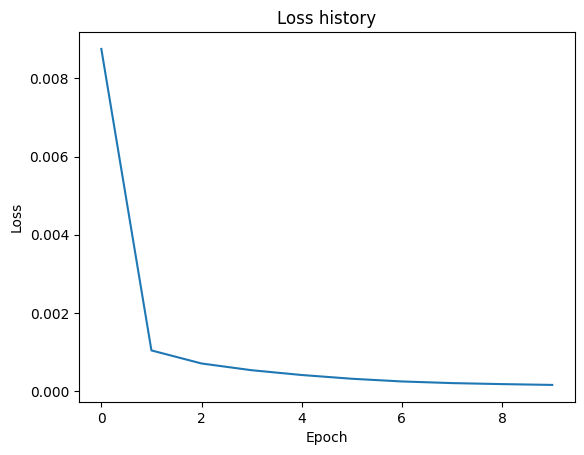

In [14]:
import matplotlib.pyplot as plt
# Plot the loss history
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

In [15]:
# Configure hyper-parameters
epochs = 5
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SC_LSTM.parameters(), lr=learning_rate)

history = []
loss_accomulator = []

In [16]:
# Now train the injector using non-reschedulable tasks
SC_LSTM.train_model(mode='injector')

for epoch in range(0, epochs):
    SC_LSTM.reset_states()

    for i, (X, Y) in enumerate(tqdm(train_resched_dataloader, desc=f"Epoch: {epoch + 1}, Mean Loss: {mean_loss}", leave=False, colour='green')):

        # Convert X and Y to the correct type
        X = torch.Tensor(X).type(torch.float32).to(device)
        Y = torch.Tensor(Y).type(torch.float32).to(device)

        # Make prediction
        Y_pred = SC_LSTM.forward(X, task_type='non-resched', free_time_slots=[[0, 1]], save_states=True)

        # Calculate loss
        loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())

    mean_loss = np.mean(loss_accomulator)
    history.append(mean_loss)
    loss_accomulator = []

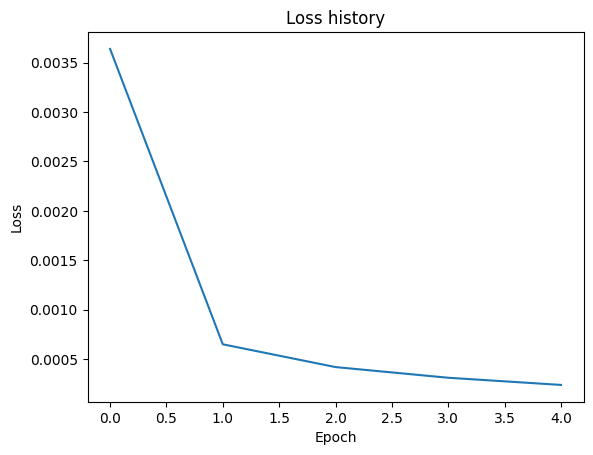

In [17]:
# Plot the loss history
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

# Save weights

In [18]:
torch.save(SC_LSTM.state_dict(), "sc_lstm_weights.pth")